# Tutorial 1: Basic Concepts in Convergence Mapping

## Introduction

Welcome to the first tutorial in the KappaBySizes series! In this tutorial, you will learn the fundamental concepts of **weak gravitational lensing** and **convergence mapping** using galaxy size distributions.

### What is Weak Gravitational Lensing?

Gravitational lensing occurs when massive objects (like dark matter halos) bend the light from more distant galaxies. This causes two main observable effects:

1. **Shape distortion (shear)**: Galaxies appear slightly elongated
2. **Size magnification (convergence)**: Galaxies appear slightly larger or smaller

### The Convergence κ (kappa)

The convergence κ quantifies the **magnification effect**. It represents the projected matter density along the line of sight:

- κ > 0: Over-dense regions → galaxies appear **larger**
- κ < 0: Under-dense regions → galaxies appear **smaller** 
- κ = 0: Average density → no magnification

The relationship is: **observed_size = intrinsic_size × (1 + κ)**

### Learning Objectives

By the end of this tutorial, you will:
1. Understand how to work with galaxy catalogues and HEALPix maps
2. Visualize galaxy size distributions
3. Generate and interpret convergence maps
4. Observe the correlation between galaxy sizes and convergence

Let's start by importing the necessary packages:

In [1]:
# Import required packages for this tutorial
import matplotlib.pyplot as plt
import healpy as hp  # HEALPix library for spherical maps
import numpy as np

# Set up plotting parameters for better visualization
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("All packages imported successfully!")
print(f"HEALPy version: {hp.__version__}")

All packages imported successfully!
HEALPy version: 1.18.1


## Part 1: Understanding Galaxy Catalogues

Galaxy catalogues contain information about thousands of galaxies observed in a survey. Each galaxy has properties like:

- **Position**: Right Ascension (RA) and Declination (Dec) coordinates
- **Redshift (z)**: Distance indicator 
- **Size (r50)**: Half-light radius
- **Other properties**: Magnitude, color, etc.

Let's load and explore a pre-generated galaxy catalogue:

In [2]:
# Load the galaxy catalogue
catalogue = np.load("catalogue.npy", allow_pickle=True)

print(f"Catalogue loaded successfully!")
print(f"Number of galaxies: {len(catalogue)}")
print(f"\nAvailable properties: {list(catalogue.dtype.names)}")

# Display basic statistics
print(f"\nBasic Statistics:")
print(f"RA range: {catalogue['ra'].min():.2f} to {catalogue['ra'].max():.2f} degrees")
print(f"Dec range: {catalogue['dec'].min():.2f} to {catalogue['dec'].max():.2f} degrees")
print(f"Redshift range: {catalogue['z'].min():.2f} to {catalogue['z'].max():.2f}")
print(f"Size range: {catalogue['r50'].min():.2f} to {catalogue['r50'].max():.2f} pixels")

Catalogue loaded successfully!
Number of galaxies: 117628

Available properties: ['gamma1', 'int_e1', 'template_coeffs', 'z', 'dec', 'ra', 'excess_b_v', 'int_mag g', 'id', 'e1', 'mag g', 'abs_mag_lumfun', 'int_e2', 'int_r50', 'e2', 'sersic_n', 'gamma2', 'galaxy_type', 'r50', 'template_coeffs_abs', 'abs_mag g', 'kappa', 'e_abs', 'bkg_noise_amp g', 'int_mag r', 'mag r', 'abs_mag r', 'bkg_noise_amp r', 'int_mag i', 'mag i', 'abs_mag i', 'bkg_noise_amp i', 'int_mag z', 'mag z', 'abs_mag z', 'bkg_noise_amp z', 'int_mag y', 'mag y', 'abs_mag y', 'bkg_noise_amp y']

Basic Statistics:
RA range: 0.00 to 90.00 degrees
Dec range: 88.54 to 90.00 degrees
Redshift range: 0.01 to 5.38
Size range: 0.05 to 24.21 pixels


**Note**: This galaxy catalogue is concentrated in a small region of the sky, corresponding to approximately one pixel in a HEALPix map with nside=64.

### Understanding HEALPix Maps

HEALPix (Hierarchical Equal Area isoLatitude Pixelization) is a standard way to divide the sphere into equal-area pixels. This is essential for cosmological analysis because:

1. **Equal areas**: Each pixel covers the same area on the sky
2. **Hierarchical**: Higher resolution maps can be created by subdividing pixels
3. **Fast spherical harmonics**: Enables efficient power spectrum analysis

### Essential HEALPix Functions

Here are the key `healpy` functions you'll use throughout these tutorials:

| Function | Purpose | Example |
|----------|---------|----------|
| `hp.nside2npix(nside)` | Get total number of pixels | `npix = hp.nside2npix(64)` |
| `hp.nside2resol(nside, arcmin=True)` | Get pixel resolution | `resol = hp.nside2resol(64, arcmin=True)` |
| `hp.ang2pix(nside, θ, φ, lonlat=True)` | Convert coordinates to pixel | `pixel = hp.ang2pix(64, ra, dec, lonlat=True)` |
| `hp.mollview(map)` | Plot full-sky map | `hp.mollview(convergence_map)` |
| `hp.cartview(map, lonra=[], latra=[])` | Plot rectangular projection | `hp.cartview(map, lonra=[0,10], latra=[-5,5])` |

**Documentation**: https://healpy.readthedocs.io/en/latest/

Let's explore these functions:

In [3]:
# Explore HEALPix parameters for different resolutions
nsides = [64, 128, 256, 512]

print("HEALPix Resolution Comparison:")
print(f"{'Nside':<8} {'N_pixels':<12} {'Resolution (arcmin)':<20} {'Resolution (degrees)':<20}")
print("-" * 70)

for nside in nsides:
    npix = hp.nside2npix(nside)
    resol_arcmin = hp.nside2resol(nside, arcmin=True)
    resol_deg = hp.nside2resol(nside, arcmin=False)
    print(f"{nside:<8} {npix:<12} {resol_arcmin:<20.2f} {resol_deg:<20.4f}")

# For our tutorial, we'll primarily use nside=64 and nside=256
print(f"\nFor nside=64: Each pixel covers {hp.nside2resol(64, arcmin=True):.1f} arcminutes")
print(f"For nside=256: Each pixel covers {hp.nside2resol(256, arcmin=True):.1f} arcminutes")

HEALPix Resolution Comparison:
Nside    N_pixels     Resolution (arcmin)  Resolution (degrees)
----------------------------------------------------------------------
64       49152        54.97                0.0160              
128      196608       27.48                0.0080              
256      786432       13.74                0.0040              
512      3145728      6.87                 0.0020              

For nside=64: Each pixel covers 55.0 arcminutes
For nside=256: Each pixel covers 13.7 arcminutes


## Part 2: Galaxy Size Distributions

Now let's examine the galaxy sizes in our catalogue. Galaxy sizes are typically measured as the half-light radius (r50) - the radius containing half of the galaxy's light.

### Converting from Pixels to Physical Units

The sizes in our catalogue are given in pixels. To understand the physical significance, we need to convert to angular units (arcseconds):

In [4]:
# Define the pixel scale for this simulation
# For this simulation, 1 pixel = 0.263 arcseconds
pixscale = 0.263  # arcsec per pixel

# Convert galaxy sizes from pixels to arcseconds
sizes_in_arcsec = catalogue['r50'] * pixscale

print(f"Pixel scale: {pixscale} arcsec/pixel")
print(f"Galaxy sizes range from {sizes_in_arcsec.min():.3f} to {sizes_in_arcsec.max():.3f} arcsec")
print(f"Mean galaxy size: {np.mean(sizes_in_arcsec):.3f} arcsec")
print(f"Median galaxy size: {np.median(sizes_in_arcsec):.3f} arcsec")

Pixel scale: 0.263 arcsec/pixel
Galaxy sizes range from 0.013 to 6.367 arcsec
Mean galaxy size: 0.245 arcsec
Median galaxy size: 0.220 arcsec


### Visualizing the Size Distribution

Let's plot the intrinsic size distribution s(θ). This represents the **unlensed** galaxy size distribution - what we would observe in the absence of gravitational lensing:

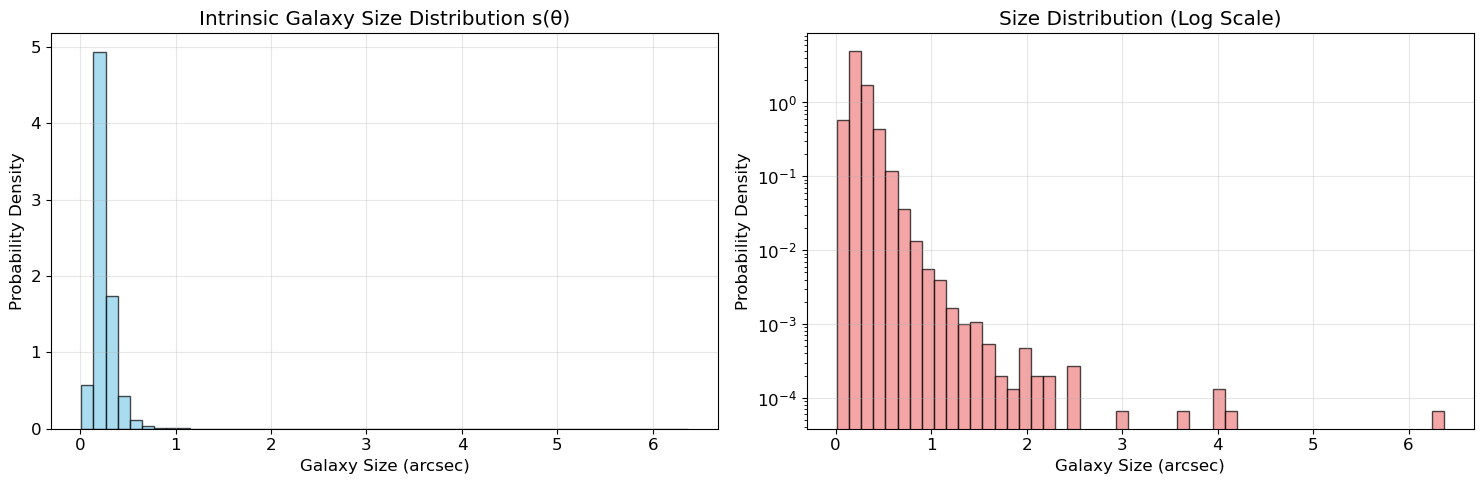


📊 Key Point: This is the 'reference' distribution that doesn't change much
when averaged over large areas, even with lensing effects!


In [5]:
# Plot the intrinsic galaxy size distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Histogram of sizes
ax1.hist(sizes_in_arcsec, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_xlabel('Galaxy Size (arcsec)')
ax1.set_ylabel('Probability Density')
ax1.set_title('Intrinsic Galaxy Size Distribution s(θ)')
ax1.grid(True, alpha=0.3)

# Also plot on log scale to see the tail
ax2.hist(sizes_in_arcsec, bins=50, density=True, alpha=0.7, color='lightcoral', edgecolor='black')
ax2.set_xlabel('Galaxy Size (arcsec)')
ax2.set_ylabel('Probability Density')
ax2.set_title('Size Distribution (Log Scale)')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Key Point: This is the 'reference' distribution that doesn't change much")
print(f"when averaged over large areas, even with lensing effects!")

## Part 3: Convergence Maps

Now let's create a convergence map. The convergence κ varies across the sky based on the matter distribution along the line of sight.

### Loading the Power Spectrum

We start with a theoretical convergence power spectrum, which describes how the convergence correlates as a function of angular separation:

In [6]:
# Load the convergence power spectrum
cl_kappa_data = np.loadtxt("cl_kappa.txt")

# The power spectrum needs to start from ℓ=0, so we add zeros for ℓ=0,1
cl_ee = np.concatenate((np.zeros(2), cl_kappa_data))

print(f"Power spectrum loaded with {len(cl_ee)} multipoles")
print(f"ℓ range: 0 to {len(cl_ee)-1}")
print(f"Power spectrum range: {cl_kappa_data.min():.2e} to {cl_kappa_data.max():.2e}")

Power spectrum loaded with 10000 multipoles
ℓ range: 0 to 9999
Power spectrum range: 3.51e-11 to 5.85e-08


### Visualizing the Power Spectrum

The power spectrum tells us about the characteristic scales of structure in the convergence field:

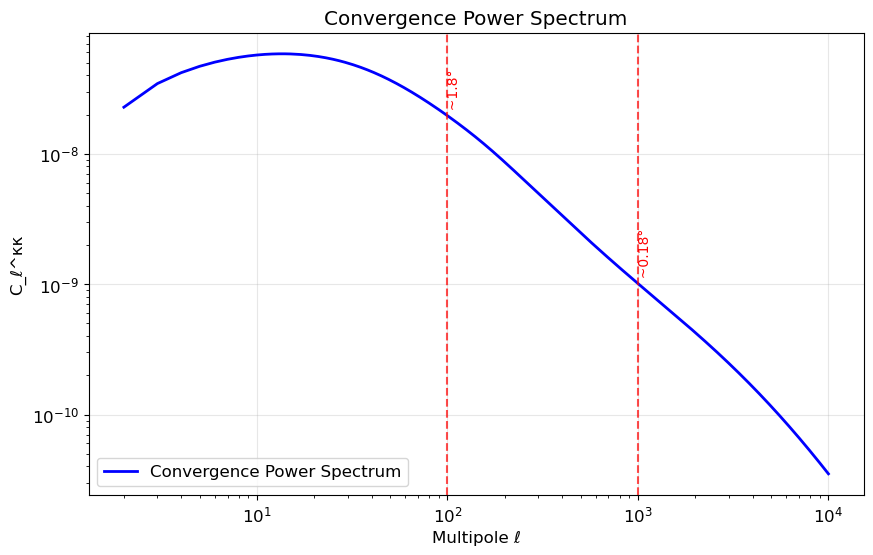


🔍 Understanding the Power Spectrum:
• Higher ℓ = smaller angular scales
• Peak location indicates characteristic correlation scale
• Angular scale ≈ 180°/ℓ


In [7]:
# Plot the convergence power spectrum
ell = np.arange(len(cl_ee))
mask = ell > 1  # Skip ℓ=0,1 which we set to zero

plt.figure(figsize=(10, 6))
plt.loglog(ell[mask], cl_ee[mask], 'b-', linewidth=2, label='Convergence Power Spectrum')
plt.xlabel('Multipole ℓ')
plt.ylabel('C_ℓ^κκ')
plt.title('Convergence Power Spectrum')
plt.grid(True, alpha=0.3)
plt.legend()

# Add annotations about angular scales
plt.axvline(x=100, color='red', linestyle='--', alpha=0.7)
plt.axvline(x=1000, color='red', linestyle='--', alpha=0.7)
plt.text(100, cl_ee[100], '  ~1.8°', rotation=90, fontsize=10, color='red')
plt.text(1000, cl_ee[1000], '  ~0.18°', rotation=90, fontsize=10, color='red')

plt.show()

print("\n🔍 Understanding the Power Spectrum:")
print("• Higher ℓ = smaller angular scales")
print("• Peak location indicates characteristic correlation scale")
print("• Angular scale ≈ 180°/ℓ")

### Generating a Convergence Map

Now we use the power spectrum to generate a random realization of the convergence field using `hp.synfast()`:

Generated convergence map with nside=128
Map statistics:
  Mean κ: 0.0000
  Std κ: 0.0099
  Range: -0.0482 to 0.0438


TypeError: Wrong argument lonra or latra. Must be lonra=[a,b],latra=[c,d] c<d, c>=-90, d<=+90

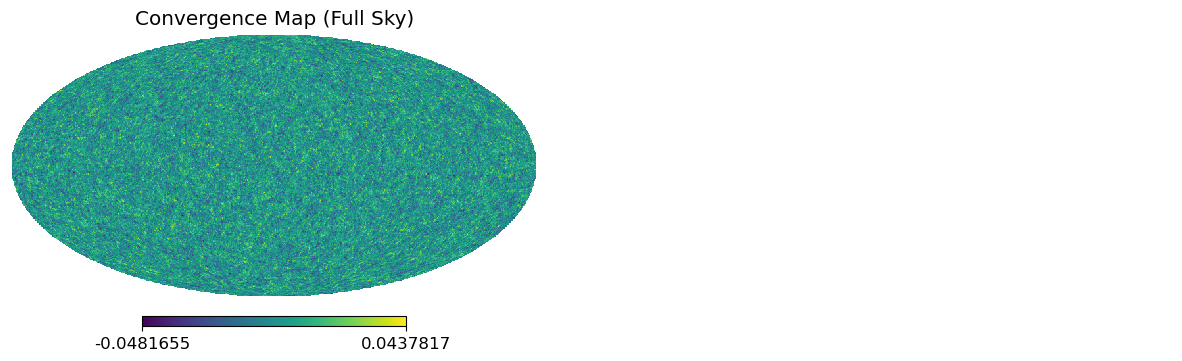

In [14]:
# Generate a convergence map from the power spectrum
nside_kappa = 128  # Resolution for the convergence map
kappamap = hp.synfast(cl_ee, nside_kappa, new=True)

print(f"Generated convergence map with nside={nside_kappa}")
print(f"Map statistics:")
print(f"  Mean κ: {np.mean(kappamap):.4f}")
print(f"  Std κ: {np.std(kappamap):.4f}")
print(f"  Range: {np.min(kappamap):.4f} to {np.max(kappamap):.4f}")

# Display the convergence map
fig = plt.figure(figsize=(15, 10))

# Full sky view
plt.subplot(2, 2, 1)
hp.mollview(kappamap, title="Convergence Map (Full Sky)", cbar=True, hold=True)

# Zoomed view around galaxy region
lon_center = np.mean(catalogue['ra'])
lat_center = np.mean(catalogue['dec'])
lon_range = 20
lat_range = 20

plt.subplot(2, 2, 2)
hp.cartview(kappamap, 
            lonra=[lon_center-lon_range/2, lon_center+lon_range/2], 
            latra=[lat_center-lat_range/2, lat_center+lat_range/2], 
            title='κ (Zoomed Region)', cbar=True, hold=True)

plt.show()

## Part 4: Applying Lensing Effects

Now we'll apply the convergence to our galaxy sizes to simulate the lensing effect. This is the core of the forward modeling approach.

### Mapping Galaxies to Convergence Values

First, we need to determine which convergence value applies to each galaxy based on its position:

In [11]:
# Map galaxy positions to HEALPix pixels
nside_galaxy = 256  # Higher resolution for galaxy positions
galaxy_pixels = hp.ang2pix(nside_galaxy, catalogue['ra'], catalogue['dec'], lonlat=True)

# Upgrade the convergence map to match galaxy resolution
kappamap_highres = hp.ud_grade(kappamap, nside_galaxy)

# Extract convergence values for each galaxy
galaxy_kappa = kappamap_highres[galaxy_pixels]

print(f"Assigned convergence values to {len(catalogue)} galaxies")
print(f"Galaxy κ statistics:")
print(f"  Mean κ: {np.mean(galaxy_kappa):.4f}")
print(f"  Std κ: {np.std(galaxy_kappa):.4f}")
print(f"  Range: {np.min(galaxy_kappa):.4f} to {np.max(galaxy_kappa):.4f}")

Assigned convergence values to 117628 galaxies
Galaxy κ statistics:
  Mean κ: 0.0017
  Std κ: 0.0095
  Range: -0.0119 to 0.0148


### Computing Lensed Sizes

Now we apply the fundamental lensing equation to compute the observed (lensed) galaxy sizes:

In [12]:
# Apply lensing: observed_size = intrinsic_size × (1 + κ)
lensed_sizes = sizes_in_arcsec * (1 + galaxy_kappa)

print(f"🔬 Lensing Results:")
print(f"Original mean size: {np.mean(sizes_in_arcsec):.4f} arcsec")
print(f"Lensed mean size: {np.mean(lensed_sizes):.4f} arcsec")
print(f"Mean magnification: {np.mean(1 + galaxy_kappa):.4f}")
print(f"Fractional change: {(np.mean(lensed_sizes) - np.mean(sizes_in_arcsec))/np.mean(sizes_in_arcsec)*100:.2f}%")

🔬 Lensing Results:
Original mean size: 0.2453 arcsec
Lensed mean size: 0.2457 arcsec
Mean magnification: 1.0017
Fractional change: 0.18%


### Visualizing the Lensing Effect

Let's compare the original and lensed size distributions, and visualize how the galaxies appear on the sky:

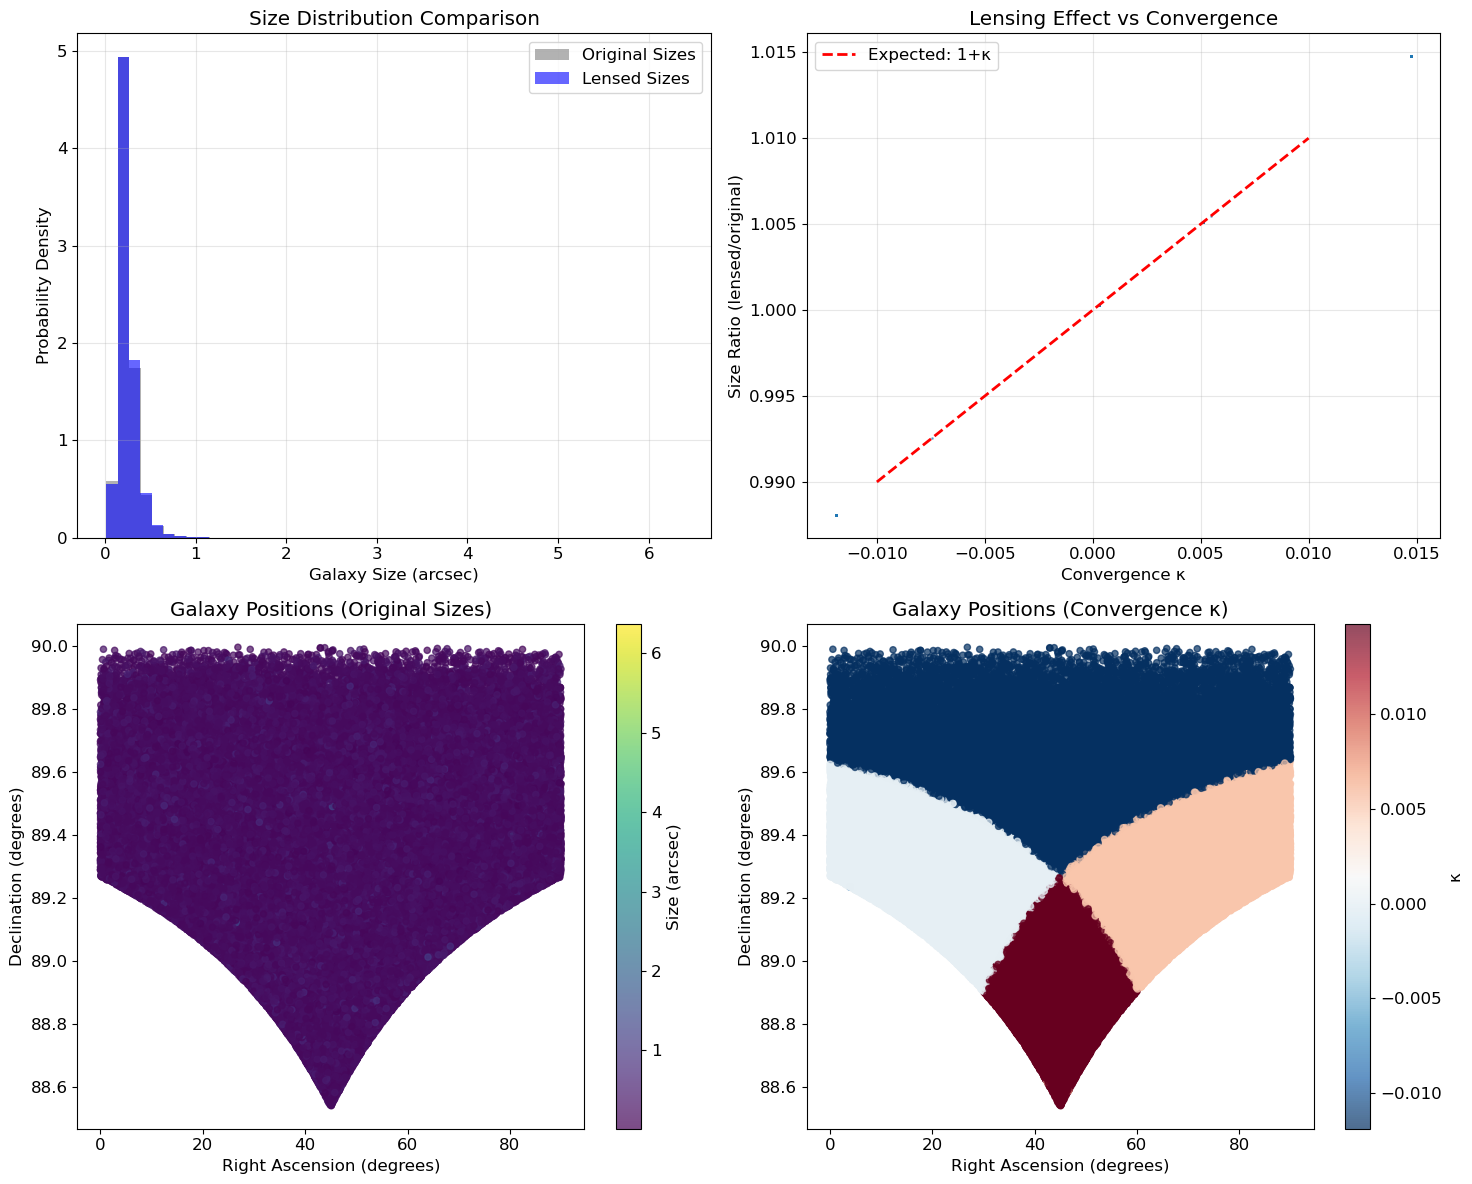

In [13]:
# Create comparison plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Size distribution comparison
ax1.hist(sizes_in_arcsec, bins=50, alpha=0.6, label="Original Sizes", color="gray", density=True)
ax1.hist(lensed_sizes, bins=50, alpha=0.6, label="Lensed Sizes", color="blue", density=True)
ax1.set_xlabel('Galaxy Size (arcsec)')
ax1.set_ylabel('Probability Density')
ax1.set_title('Size Distribution Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Size vs convergence correlation
ax2.scatter(galaxy_kappa, lensed_sizes/sizes_in_arcsec, alpha=0.5, s=1)
ax2.plot([-0.01, 0.01], [0.99, 1.01], 'r--', linewidth=2, label='Expected: 1+κ')
ax2.set_xlabel('Convergence κ')
ax2.set_ylabel('Size Ratio (lensed/original)')
ax2.set_title('Lensing Effect vs Convergence')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Galaxy positions colored by original size
scatter1 = ax3.scatter(catalogue['ra'], catalogue['dec'], 
                      c=sizes_in_arcsec, s=20, cmap='viridis', alpha=0.7)
ax3.set_xlabel('Right Ascension (degrees)')
ax3.set_ylabel('Declination (degrees)')
ax3.set_title('Galaxy Positions (Original Sizes)')
plt.colorbar(scatter1, ax=ax3, label='Size (arcsec)')

# 4. Galaxy positions colored by convergence
scatter2 = ax4.scatter(catalogue['ra'], catalogue['dec'], 
                      c=galaxy_kappa, s=20, cmap='RdBu_r', alpha=0.7)
ax4.set_xlabel('Right Ascension (degrees)')
ax4.set_ylabel('Declination (degrees)')
ax4.set_title('Galaxy Positions (Convergence κ)')
plt.colorbar(scatter2, ax=ax4, label='κ')

plt.tight_layout()
plt.show()

## Part 5: Key Insights and Summary

### What We've Learned

1. **Convergence Effect**: The convergence κ directly affects galaxy sizes through the relation `observed_size = intrinsic_size × (1 + κ)`

2. **Correlation Scales**: The convergence varies smoothly across the sky on scales much larger than typical galaxy separations

3. **Statistical Approach**: While individual galaxy sizes are noisy, statistical comparisons of size distributions can reveal convergence information

4. **Global vs Local**: The global size distribution changes very little with lensing, but local variations can be significant

### Key Questions for Students

💭 **Think about these questions:**

1. Why does the global galaxy size distribution remain relatively unchanged by lensing?
2. How could you detect convergence by comparing local vs global size distributions?
3. What would happen if you had a much denser galaxy catalog?
4. How might observational noise affect this analysis?

### Next Steps

In the next tutorials, you will learn:
- How to generate realistic galaxy catalogues using GalSBI
- How to work with redshift distributions and cosmological models
- How to build estimators to recover convergence from size distributions
- Advanced topics like lognormal models for κ

In [ ]:
# Final summary statistics
print("📋 TUTORIAL 1 SUMMARY")
print("=" * 50)
print(f"Galaxies analyzed: {len(catalogue):,}")
print(f"Sky area coverage: ~{(np.max(catalogue['ra']) - np.min(catalogue['ra'])) * (np.max(catalogue['dec']) - np.min(catalogue['dec'])):.1f} deg²")
print(f"Mean convergence: {np.mean(galaxy_kappa):.4f}")
print(f"RMS convergence: {np.std(galaxy_kappa):.4f}")
print(f"Typical size change: {np.std(galaxy_kappa)*100:.2f}%")
print("\n✅ You've completed Tutorial 1!")
print("🚀 Ready for Tutorial 2: Galaxy Catalogue Generation")